In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from cleaning import load_and_clean

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from model.nbm_model import ConceptNBMNary
from utils.plot_shapefunc import plot_nbm_shape_functions_with_feature_density, permutation_importance, plot_feature_importance
from tqdm import tqdm

# fix random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
### clean data, select features
# load data
data = pd.read_csv('data/diabetic_data.csv')

# clean data
data_clean = load_and_clean(data)

# set X and y
## set features
features = ['total_previous_visits', 'discharge_disposition_id', 'num_lab_procedures', 'time_in_hospital', 'number_diagnoses', 'age']


X = data_clean[features]  # Features
y = data_clean['readmit30']  # Target variable

In [16]:
### create training and testing
# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# For NumPy arrays (X data)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# For pandas Series (y data)
# Convert to NumPy arrays first
y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

# Then create tensors
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32).unsqueeze(1)

# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [26]:
### set up model
# Define the model hyperparameters
num_concepts = X_train_tensor.shape[1]  # number of features (8 for California Housing)
num_classes = 1  # regression output is a single continuous value
num_bases = 100
hidden_dims = (256, 128, 128)
num_subnets = 1
dropout = 0.0
bases_dropout = 0.2
batchnorm = True

# Instantiate the model (nary is left as None so that it uses all unary interactions)
model = ConceptNBMNary(
    num_concepts=num_concepts,
    num_classes=num_classes,
    nary=None,
    num_bases=num_bases,
    hidden_dims=hidden_dims,
    num_subnets=num_subnets,
    dropout=dropout,
    bases_dropout=bases_dropout,
    batchnorm=batchnorm
)

# Use Mean Squared Error for regression
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [27]:
### fit the model
# Train the model
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        optimizer.zero_grad()
        # In training mode, the model returns a tuple: (output, features)
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# test the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in tqdm(test_loader, desc="Testing", leave=False):
        # In eval mode, the model returns only the output
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    test_loss = total_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}") 
print(f"RMSE: {test_loss**0.5:.4f}")  

Epoch 1/50 - Loss: 0.3405


Epoch 2/50 - Loss: 0.3362


Epoch 3/50 - Loss: 0.3359


Epoch 4/50 - Loss: 0.3356


Epoch 5/50 - Loss: 0.3352


Epoch 6/50 - Loss: 0.3353


Epoch 7/50 - Loss: 0.3350


Epoch 8/50 - Loss: 0.3351


Epoch 9/50 - Loss: 0.3346


Epoch 10/50 - Loss: 0.3347


Epoch 11/50 - Loss: 0.3345


Epoch 12/50 - Loss: 0.3345


Epoch 13/50 - Loss: 0.3343


Epoch 14/50 - Loss: 0.3342


Epoch 15/50 - Loss: 0.3339


Epoch 16/50 - Loss: 0.3345


Epoch 17/50 - Loss: 0.3341


Epoch 18/50 - Loss: 0.3345


Epoch 19/50 - Loss: 0.3340


Epoch 20/50 - Loss: 0.3341


Epoch 21/50 - Loss: 0.3338


Epoch 22/50 - Loss: 0.3342


Epoch 23/50 - Loss: 0.3339


Epoch 24/50 - Loss: 0.3336


Epoch 25/50 - Loss: 0.3337


Epoch 26/50 - Loss: 0.3342


Epoch 27/50 - Loss: 0.3340


Epoch 28/50 - Loss: 0.3339


Epoch 29/50 - Loss: 0.3338


Epoch 30/50 - Loss: 0.3339


Epoch 31/50 - Loss: 0.3338


Epoch 32/50 - Loss: 0.3337


Epoch 33/50 - Loss: 0.3340


Epoch 34/50 - Loss: 0.3338


Epoch 35/50 - Loss: 0.3339


Epoch 36/50 - Loss: 0.3342


Epoch 37/50 - Loss: 0.3340


Epoch 38/50 - Loss: 0.3339


Epoch 39/50 - Loss: 0.3339


Epoch 40/50 - Loss: 0.3338


Epoch 41/50 - Loss: 0.3337


Epoch 42/50 - Loss: 0.3337


Epoch 43/50 - Loss: 0.3337


Epoch 44/50 - Loss: 0.3338


Epoch 45/50 - Loss: 0.3342


Epoch 46/50 - Loss: 0.3338


Epoch 47/50 - Loss: 0.3339


Epoch 48/50 - Loss: 0.3338


Epoch 49/50 - Loss: 0.3339


Epoch 50/50 - Loss: 0.3338


Test Loss: 0.3374
RMSE: 0.5809


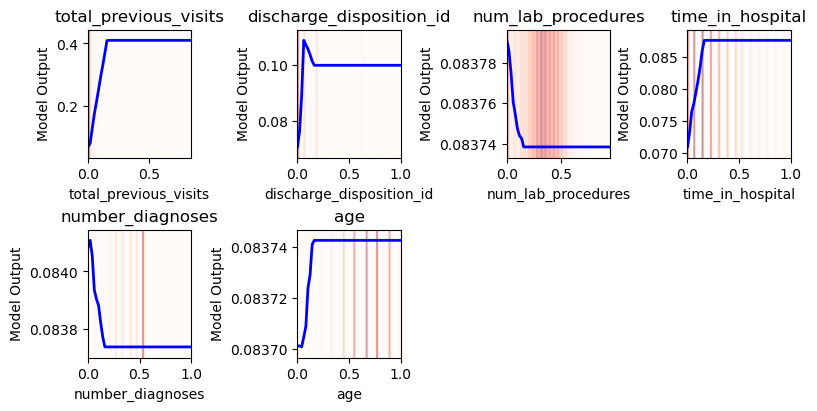

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Move everything to CPU for consistency
model = model.to('cpu')
model.eval()

# Get predictions for all test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    # Get raw predictions
    predictions = model(X_test_tensor)
    
    # For binary classification
    probabilities = torch.sigmoid(predictions).squeeze().numpy()
    binary_preds = (probabilities > 0.5).astype(int)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'actual': y_test,
    'probability': probabilities,
    'prediction': binary_preds
})

# Display the first few rows
print(results_df.head())

# Evaluate the model
accuracy = accuracy_score(y_test, binary_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, binary_preds))

In [28]:
### plot shape functions
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model.eval()
model.to(device)

plot_nbm_shape_functions_with_feature_density(
    model,
    X_test, 
    feature_names=features,
    n_points=50,   # more points for a smoother curve
    bins=50,        # more histogram bins
    device=device,
    plot_cols=4,
    red_alpha=0.4
)

       actual  probability  prediction
35956       0     0.089942           0
60927       0     0.081711           0
79920       0     0.188301           0
50078       0     0.122789           0
44080       1     0.126890           0
Accuracy: 0.8876
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.00      0.00      0.00      2285

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.83     20354



In [30]:
## compare against logistic
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]


results_df = pd.DataFrame({
    'actual': y_test,
    'probability': lr_probs
})
print(f"LR probabilities range: {lr_probs.min():.4f} to {lr_probs.max():.4f}")

LR probabilities range: 0.0500 to 0.9998
